In [1]:
import pickle
import os
import pandas as pd

output_dir = "outputs"
splitted_docs = pickle.load(open(os.path.join(output_dir, "split_docs.pkl"), 'rb'))
qa_df = pd.read_json(os.path.join(output_dir, "qa.json"), lines=True)

In [2]:
from langchain.embeddings import init_embeddings
from langchain.chat_models import init_chat_model
from langchain_chroma import Chroma
import dotenv
import os
dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("API_KEY", "")
os.environ["OPENAI_BASE_URL"] = os.getenv("BASE_URL", "")

embeddings = init_embeddings(
    model="openai:text-embedding-3-small",
)

vector_db = Chroma.from_documents(
    documents=splitted_docs,
    persist_directory= os.path.join(output_dir, 'chromadb_v1'),
    embedding=embeddings
)
retriver = vector_db.as_retriever(search_kwargs={'k': 8})
llm = init_chat_model(
    model='openai:gpt-4o-mini',
    temperature = 0.8,
    top_p = 0.85
)


/Users/yuke/github/llm-learning/langchain/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing_extensions import List
from langchain_core.prompts import PromptTemplate
class Query(BaseModel):
    queries: List[str] = Field([], description="请生成三个类似的回答, 并且把原始问题放在最开始，即四个字符串的列表")

query_parser = PydanticOutputParser(pydantic_object=Query)

query_prompt = PromptTemplate.from_template(
    template="给你一个问题：{query}, 请生成三个类似的问题，并且按照这个结构{format}输出答案",
    partial_variables={'format': query_parser.get_format_instructions()}
)

def format_query(responses):
    queries = list(responses.queries)
    return ' '.join(query for query in queries)

chain = (
    query_prompt
    | llm 
    | query_parser
    | format_query
    | retriver
)

chain.invoke({'query': '报告的发布机构是什么？'})

[Document(id='defdb877-7a3e-4b75-936b-5402910dde41', metadata={'uuid': '35e5de15-d070-498f-8ffc-447971614d05'}, page_content='研究院\n全球经济金融展望报告\n要点\n2024年年报（总第 57期） 报告日期：2023年 12月 12日\n● 2023 年全球经济增长动力持续回落，各国复苏分化，\n发达经济体增速明显放缓，新兴经济体整体表现稳定。\n全球贸易增长乏力，各国生产景气度逐渐回落，内需\n对经济的拉动作用减弱。欧美央行货币政策紧缩态势\n放缓，美元指数高位震荡后走弱，全球股市表现总体\n好于预期，但区域分化明显。高利率环境抑制债券融\n资需求，债券违约风险持续上升。\n● 展望 2024 年，预计全球经济复苏将依旧疲软，主要\n经济体增长态势和货币政策走势将进一步分化。欧美\n央行大概率结束本轮紧缩货币周期，美元指数将逐步\n走弱，流向新兴经济体的跨境资本将增加。国际原油\n市场短缺格局或延续，新能源发展成为重点。\n● 海湾六国经济发展与投资前景、高利率和高债务对\n美国房地产市场脆弱性的影响等热点问题值得关注。\n中国银行研究院\n全球经济金融研究课题组\n组 长： 陈卫东\n副组长： 钟 红\n廖淑萍\n成 员： 边卫红\n熊启跃\n王有鑫\n曹鸿宇\n李颖婷\n王宁远\n初 晓\n章凯莉\n黄小军（纽约）\n陆晓明（纽约）\n黄承煜（纽约）\n宋达志（伦敦）\n李振龙（伦敦）\n张传捷（伦敦）\n刘冰彦（法兰克福）\n温颍坤（法兰克福）\n张明捷（法兰克福）\n王 哲（东京）\n李 彧（香港）\n黎永康（香港）\n联系人：王有鑫\n电 话：010-66594127\n邮 件：wangyouxin_hq@bank-of-china.com\n主要经济体 GDP 增速变化趋势（%）\n资料来源：IMF，中国银行研究院'),
 Document(id='c8df6d37-a2be-4a94-94b9-91c3c7492d10', metadata={'uuid': '6f3ee073-e21b-455d-b89b-b188aa3a284c'}, page_content='场仍处于下行周期的早期阶段。基于历史经验，叠加长期结构性因

In [10]:
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
top_k_arr = list(range(1, 9))
hit_state_data = []

def process_row(row):
    question = row['question']
    true_uuid = row['uuid']
    chunks = chain.invoke({'query': question})
    retrive_uuids = [doc.metadata['uuid'] for doc in chunks]
    row_results = []
    for k in range(1, 9):
        row_results.append({
            'question': question,
            'top_k': k,
            'hit': int(true_uuid in retrive_uuids[:k])
        }) 
    return row_results

with ThreadPoolExecutor(max_workers=16) as excecutor:
    futures = [excecutor.submit(process_row, row) for idx, row in qa_df.iterrows()]
    for future in tqdm(as_completed(futures), total=len(qa_df)):
        try:
            hit_state_data.extend(future.result())
        except Exception as exc:
            print(f"异常：{exc}")

hit_state_df = pd.DataFrame(hit_state_data)
hit_state_df.sample(10)

100%|██████████| 401/401 [02:57<00:00,  2.25it/s]


,question,top_k,hit
1630,美联储为了应对通胀采取了什么措施？,7,1
2604,COP28大会对中东国家的发展有何影响？,5,1
1635,美国金融市场的整体状态是什么？,4,1
2756,习近平主席在2022年12月的峰会上提出了什么样的伙伴关系概念？,5,1
2447,黄金的避险功能将在2024年如何表现？,8,1
2159,绿色能源板块在2024年受到怎样的关注？,8,1
2574,2022年海湾六国的实际GDP增速是多少？,7,1
1253,菲律宾和印度尼西亚的居民消费支出同比增长了多少？,6,1
2042,日本股市在2023年的表现如何？,3,1
991,欧盟委员会在2023年10月对中国电动汽车做了什么决定？,8,1


   top_k       hit      dataset
0      1  0.531172  multi_query
1      2  0.698254  multi_query
2      3  0.763092  multi_query
3      4  0.825436  multi_query
4      5  0.852868  multi_query
5      6  0.882793  multi_query
6      7  0.900249  multi_query
7      8  0.907731  multi_query
   top_k    hit   dataset
0      1  0.405  baseline
1      2  0.580  baseline
2      3  0.665  baseline
3      4  0.715  baseline
4      5  0.755  baseline
5      6  0.795  baseline
6      7  0.840  baseline
7      8  0.855  baseline


<Axes: xlabel='top_k', ylabel='hit'>

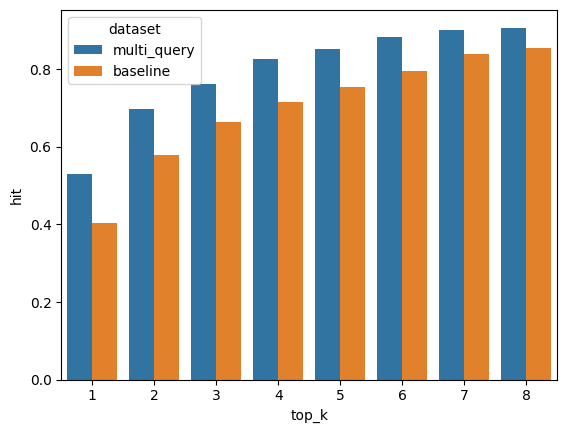

In [12]:
temp = hit_state_df.groupby('top_k')['hit'].mean().reset_index()
data = [
    {'top_k': 1, 'hit': 0.405},
    {'top_k': 2, 'hit': 0.580},
    {'top_k': 3, 'hit': 0.665},
    {'top_k': 4, 'hit': 0.715},
    {'top_k': 5, 'hit': 0.755},
    {'top_k': 6, 'hit': 0.795},
    {'top_k': 7, 'hit': 0.840},
    {'top_k': 8, 'hit': 0.855}
]

base = pd.DataFrame(data)
base['dataset'] = 'baseline'
temp['dataset'] = 'multi_query'
concat_df = pd.concat([temp, base], ignore_index=True)
print(temp)
print(base)
import seaborn as sns
sns.barplot(x='top_k', y='hit', hue='dataset', data=concat_df)
